In [84]:
from typing import Union, List, Any, Optional, Dict

import os
import re
import time
import json
import glob
import pickle
import random
import urllib
import requests
import subprocess
import concurrent.futures

import numpy as np
import pandas as pd
import seaborn as sns

from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path
from textblob import TextBlob
from threading import current_thread
from matplotlib import pyplot as plt
from collections import Counter
from transformers import BertTokenizer, BertModel
from gap_statistic import OptimalK
from sklearn.cluster import KMeans #, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

try:
    from libKMCUDA import kmeans_cuda
except:
    print("KM cuda not found, defaulting to sklearn CPU version of kmeans")
    kmeans_cuda = None

from utils import cleaning_utils
from utils import cluster_utils
from utils import IDF_computation
from utils import embedding_utils as embedding
from utils.customdocument import CustomDocument

KM cuda not found, defaulting to sklearn CPU version of kmeans


<div class="alert alert-block alert-info"> 
We will run our term extraction on the Merged Approved Documents, the .pdf file can be found in the `data/` directory. For filtering of out-of-domain terms we will also process a set of EU regulations for medical device design, the .html files for these can be found in the same directory.
</div>

1. Preprocessing will consist only of removing headers/footers from PDF files. 

2. Candidate terms are identified using SPaR.txt (Kruiper et al., 2021), sentence splitting is done with the PunkSentTokenizer (Strunk, 2006).

3. Filtering of term candidates consists of:
  * a set of regular expressions found in utils.py
  * clustering of terms found in (1) the Approved Documents, and (2) a set of EU regulations for medical device design; any clusters containing terms from (2) will be designated as terms that are irrelevant to the AEC domain.
  
 


### 1 Preprocessing: get text from PDF and HTML

<div class="alert alert-block alert-info">
Here, we grab the text from our foreground and background corpora.
</div>


In [2]:
merged_approved_pdf_file = glob.glob("data/input/*.pdf")[0]
eu_html_files = glob.glob("data/input/*.html")
print(f"Approved Documents: {merged_approved_pdf_file}")
print(f"Reference corpus: {eu_html_files}")

Approved Documents: data/input/The Merged Approved Documents.pdf
Reference corpus: ['data/input/EUR-Lex - 31993L0042 - EN.html', 'data/input/CELEX 32017R0746 EN TXT.html', 'data/input/CELEX 32017R0745 EN TXT.html', 'data/input/EUR-Lex - 31998L0079 - EN.html', 'data/input/EUR-Lex - 31990L0385 - EN.html']


<div class="alert alert-block alert-info">
First we grab the text from the Merged Approved Documents pdf file. Our implementation on based on the pdf conversion pipeline in Haystack.
</div>

In [3]:
def read_pdf(file_path: Path, layout: bool = True, encoding: Optional[str] = "Latin1") -> List[str]:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param file_path: path of the pdf file
        :param layout: whether to retain the original physical layout for a page. If disabled, PDF pages are read in
                       the content stream order.
        """
        if layout:
            command = ["pdftotext", "-enc", encoding, "-layout", str(file_path), "-"]
        else:
            command = ["pdftotext", "-enc", encoding, str(file_path), "-"]
        output = subprocess.run(command, stdout=subprocess.PIPE, shell=False)  # type: ignore
        document = output.stdout.decode(errors="ignore")
        pages = document.split("\f")
        pages = pages[:-1]  # the last page in the split is always empty.
        return pages

def convert_pdf_to_mydoc(source_file_path: Path, 
                         output_file_path: Path, 
                         meta: Optional[Dict[str, str]] = None,
                         remove_header_and_footer: Optional[bool] = True,
                         clean_whitespace: Optional[bool] = True,
                         clean_empty_lines: Optional[bool] = True,
                         encoding: Optional[str] = "Latin1") -> CustomDocument:
        """
        Extract pages from the pdf file at file_path; based on Haystack.

        :param output_file_path:    Path to the .json file to store the converted file.
        :param source_file_path:    Path to the .pdf file you want to convert
        :param meta: Optional dictionary with metadata that shall be attached to all resulting documents.
                     Can be any custom keys and values.
        :param encoding: Encoding that will be passed as -enc parameter to pdftotext. "Latin 1" is the default encoding
                         of pdftotext. While this works well on many PDFs, it might be needed to switch to "UTF-8" or
                         others if your doc contains special characters (e.g. German Umlauts, Cyrillic characters ...).
                         Note: With "UTF-8" we experienced cases, where a simple "fi" gets wrongly parsed as
                         "xef\xac\x81c" (see test cases). That's why we keep "Latin 1" as default here.
                         (See list of available encodings by running `pdftotext -listenc` in the terminal)
        """
        pages = read_pdf(source_file_path, layout=True, encoding=encoding)

        if not pages:
            # empty input file
            return None
        
        pages = ["\n".join(p.splitlines()) for p in pages]

        # splitting text happens during preprocessing, so no split_size passed here;
        # split_size will be set to -1 during conversion.
        document = CustomDocument(output_file_path, source_file_path, split_size=-1)
        
        print("Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.")
        for page_idx, page in tqdm(enumerate(pages)):
            
            # some simple cleaning -- roughly based on haystack.
            lines = page.splitlines()
            if remove_header_and_footer:
                # simplest way for removing header and footer 
                lines = lines[1:-2]

            if clean_whitespace:
                cleaned_lines = []
                for line in lines:
                    line = line.strip()
                    cleaned_lines.append(line)
                text = " ".join(cleaned_lines)

            if clean_empty_lines:
                text = re.sub(r"\n\n+", "\n\n", text)
                text = re.sub(r"[\s]+", " ", text)
            
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            page_nr = str(page_idx + 1)
            document.add_content(text=text, 
                                 page_nr=page_nr, 
                                 doc_title=source_file_path.rsplit('/',1)[1])   # we're using the pdf file name for simplicity

        return document

In [4]:
merged_approved_document = convert_pdf_to_mydoc(merged_approved_pdf_file, "data/converted_documents/merged_approved.json")

Converted PDF file to pages of text, combining to a single CustomDocument to keep track of page nrs.


1274it [00:00, 6863.53it/s]


In [5]:
print(f"Maximum character length for a single block of text: {max([len(c.text) for c in merged_approved_document.all_contents])}")

Maximum character length for a single block of text: 5537


<div class="alert alert-block alert-info">
Second, we grab the text from the EU regulation HTML files. Because the text in HTML files isn't split into pages, the blocks of text are much longer.
</div>

In [6]:
def grab_HTML_text_simple(file):
    """
    All text in the EU htmls seems to be captured neatly in <p> tags, we don't care about structure currently.
    We do remove all unicode characters, see `utils.remove_unicode_chars()`.
    """ 
    with open(file, 'r') as f:
        text = f.read()
    soup = BeautifulSoup(text, 'html.parser')
    return [cleaning_utils.remove_unicode_chars(x.text) for x in soup.body.find_all('p')]

In [7]:
def convert_html_to_mydoc(source_file_path: Path, 
                          output_file_path: Path) -> CustomDocument:
    
    document = CustomDocument(output_file_path, source_file_path, split_size=-1)
    document_paragraphs = []
    list_of_paragraphs = grab_HTML_text_simple(html_file)
    for paragraph in list_of_paragraphs:
        if paragraph.strip() != '':
            document_paragraphs.append(paragraph)
    
    for paragraph_idx, paragraph in tqdm(enumerate(document_paragraphs)):
            # no splitting here yet, so simply using page_nr as a place holder and split_id is left blank
            paragraph_nr = str(paragraph_idx + 1)
            document.add_content(text=paragraph, 
                                 page_nr=paragraph_nr, 
                                 doc_title=source_file_path) # we're using the html file name for simplicity
    return document

In [8]:
eu_regulation_documents = []
for html_file in tqdm(eu_html_files):
    outfile = f"data/converted_documents/{html_file.rsplit('/',1)[1]}.json"
    eu_regulation_documents.append(convert_html_to_mydoc(html_file, outfile))


  0%|                                                                                                                                                                                 | 0/5 [00:00<?, ?it/s]
826it [00:00, 303238.08it/s]

4344it [00:00, 373384.77it/s]
 40%|███████████████████████████████████████████████████████████████████▌                                                                                                     | 2/5 [00:00<00:01,  2.26it/s]
4799it [00:00, 356748.52it/s]
 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 3/5 [00:01<00:01,  1.65it/s]
623it [00:00, 305548.57it/s]

0it [00:00, ?it/s]
511it [00:00, 4549.18it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.63it/s]


In [9]:
print(f"Maximum character length for a single paragraph: {max([len(c.text) for d in eu_regulation_documents for c in d.all_contents])}")

Maximum character length for a single paragraph: 143428


<div class="alert alert-block alert-info">
Third, if the output document doesn't exist (yet), we save the ConvertedDocument.
</div>

In [10]:
foreground_corpus = [merged_approved_document]
background_corpus = eu_regulation_documents

In [11]:
for d in foreground_corpus + background_corpus:
    if not os.path.exists(d.output_fp):
        d.write_document()

### 2 Term extraction: identify object spans with SPaR.txt

<div class="alert alert-block alert-info">
For each of the sentences in our corpora, we run SPaR.txt for object identification.
</div>



In [12]:
# download SPaR.txt if required
if not os.path.exists("SPaR.txt/README.md"):
    !git clone https://github.com/rubenkruiper/SPaR.txt.git

In [13]:
import imp
with open('SPaR.txt/spar_predictor.py', 'rb') as fp:
    spar_predictor = imp.load_module(
        'spar_predictor', fp, 'SPaR.txt.spar_predictor.py',
        ('.py', 'rb', imp.PY_SOURCE)
    )

In [14]:
# trains a model if needed, otherwise loads from archive; 
# - best F1 on dev/validation in the paper is 80,96 trained on a GPU, CPU will be a bit lower ~77.x I think
sp = spar_predictor.SparPredictor()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
# example 
example = "An example sentence to show how ACC terminology will be extracted from the British Standards."
start_time = time.time()
# prepare instance and run model on single instance
docid = ''                  # ToDo - add doc_id during pre_processing?
token_list = sp.predictor._dataset_reader.tokenizer.tokenize(example)
instance = sp.predictor._dataset_reader.text_to_instance(docid,
                                                      example,
                                                      token_list,
                                                      sp.predictor._dataset_reader._token_indexer)
result = sp.predictor.predict_instance(instance)
printable_result = sp.parse_output(result, ['obj'])
print(f"Example input: {example}")
print(printable_result)
print("Parsing took {}".format(time.time() - start_time))

Example input: An example sentence to show how ACC terminology will be extracted from the British Standards.
{'obj': ['An example sentence', 'ACC terminology', 'the British Standards']}
Parsing took 0.11161375045776367


* To run SPaR.txt, we split the text in our corpora into sentences. We set up multiple instances of SPaR.txt predictors to speed up the processing a little.

In [16]:
# These should automatically run on your Nvidia GPU if available
class SparInstance:
    def __init__(self):
        self.sp = spar_predictor.SparPredictor()
    
    def call(self, input_str:str=''):
        if input_str:
            # prepare instance and run model on single instance
            docid = ''  # ToDo - add doc_id during pre_processing?
            token_list = self.sp.predictor._dataset_reader.tokenizer.tokenize(input_str)

            # truncating the input to SPaR.txt to maximum 512 tokens
            token_length = len(token_list)
            if token_length > 512:
                token_list = token_list[:511] + [token_list[-1]]
                token_length = 512

            instance = self.sp.predictor._dataset_reader.text_to_instance(docid, input_str, token_list,
                                                              self.sp.predictor._dataset_reader._token_indexer)
            result = self.sp.predictor.predict_instance(instance)
            printable_result = self.sp.parse_output(result, ['obj'])
            return {
                    "prediction": printable_result,
                    "num_input_tokens": token_length,
            }
            
        # If the input is None, or too long, return an empty list of objects
        return {
                "prediction": {'obj': []},
                "num_input_tokens": 0
            }


In [17]:
class TermExtractor:
    
    def __init__(self, split_length=300, max_num_cpu_threads=4):
        """
        Initialise SPaR.txt predictors `max_num_cpu_threads` 
        """
        self.split_length = split_length   # in number of tokens
        self.max_num_cpu_threads = max_num_cpu_threads
        self.PREDICTORS = []
        for i in range(max_num_cpu_threads + 1):
            self.PREDICTORS.append(SparInstance())
    
    
    def process_sentence(self, sentence: str = ''):
        """
        """
        predictor_to_use = int(current_thread().name.rsplit('_', 1)[1])
        spartxt = self.PREDICTORS[predictor_to_use]

        # SPaR doesn't handle ALL uppercase sentences well, which the OCR system sometimes outputs    
        sentence = sentence.lower() if sentence.isupper() else sentence
        prediction_dict =  spartxt.call(sentence)
        if not prediction_dict:
            return []

        pred_labels = prediction_dict["prediction"]
        return pred_labels['obj']
        

    def split_into_sentences_and_run_spar(self, input_document):
        """
        """
        print(f"Working on: {input_document.source_fp}")
        content_as_list_of_dicts = input_document.to_list_of_dicts()
        total_number_of_sentences_found = 0
        content_idx = 0
        for content_dict in tqdm(content_as_list_of_dicts):

            text = ' '.join([x for x in content_dict["content"].split(' ') if x != ''])
            # some really long paragraphs in the EU regulations are summations that should be split at ';'
            if len(text) > 3000:
                text = text.replace(";", ".\n")

            # We'll split into sentences even if this has been done before, it doesn't take long
            sentences = []
            for part in text.split('\n'):
                # split into sentences using PunktSentTokenizer (TextBlob implements NLTK's version under the hood) 
                sentences += [str(s) for s in TextBlob(part).sentences if len(str(s)) > 10]

            content_dict["meta"]["sentences"] = '###'.join(sentences)
                
            total_number_of_sentences_found += len(sentences)

            # process sentences in the content and add SPaR.txt object tags to the content dict.        
            if not content_dict["meta"]["SPaR_labels"]:
                with concurrent.futures.ThreadPoolExecutor(max_workers=self.max_num_cpu_threads) as executor:
                    futures = [executor.submit(self.process_sentence, sentences[idx]) for idx in range(len(sentences))]

                content_spar_objects = [f.result() for f in futures]
                content_dict["meta"]["SPaR_labels"] = ', '.join([tag for tags in content_spar_objects for tag in tags])
                
            # immediately update the list of content_dicts and every X iterations we save the file 
            content_as_list_of_dicts[content_idx] = content_dict
            if content_idx // 5 == 0:
                converted_document.replace_contents(content_as_list_of_dicts)
                converted_document.write_document()
            
            content_idx += 1

        print(f"Number of sentences found: {total_number_of_sentences_found}")
        converted_document.replace_contents(content_as_list_of_dicts)
        converted_document.write_document()
        

In [18]:
te = TermExtractor()

In [20]:
# Run SPaR.txt on all documents and write to file
for converted_document in foreground_corpus + background_corpus:
    # re-load the document from file, to make sure we don't overwrite existing SPaR.txt labels
    converted_document = converted_document.load_document(converted_document.output_fp)
    te.split_into_sentences_and_run_spar(converted_document)
    

Working on: data/input/The Merged Approved Documents.pdf


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1274/1274 [00:01<00:00, 807.11it/s]


Number of sentences found: 17745
Working on: data/input/EUR-Lex - 31993L0042 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 826/826 [00:00<00:00, 3872.14it/s]


Number of sentences found: 1679
Working on: data/input/CELEX 32017R0746 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4344/4344 [00:01<00:00, 2736.39it/s]


Number of sentences found: 3405
Working on: data/input/CELEX 32017R0745 EN TXT.html


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4799/4799 [00:01<00:00, 3206.10it/s]


Number of sentences found: 3838
Working on: data/input/EUR-Lex - 31998L0079 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 623/623 [00:00<00:00, 2889.35it/s]


Number of sentences found: 1255
Working on: data/input/EUR-Lex - 31990L0385 - EN.html


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 511/511 [00:00<00:00, 4866.72it/s]

Number of sentences found: 771


<div class="alert alert-block alert-info">
Number of sentences (longer than 10 characters) found in: <ul>
    <li>Merged Approved documents: 17745</li>
    <li>Background corpus (1679+3405+3838+1255+771): 10948</li>
    </ul>
</div>

### 3 Filtering
<div class="alert alert-block alert-info">
The objects identified by SPaR.txt contain a lot of noise. Here, we clean and filter them; based on our background corpus we try to identify which terms belong to the AEC domain. 
</div>

<div class="alert alert-block alert-info">
First, load all terms from the processed files.
</div>

In [21]:
foreground_terms_lists = [c.NER_labels for d in foreground_corpus for c in d.load_document(d.output_fp).all_contents]
foreground_terms = [t for t_list in foreground_terms_lists for t in t_list if t]
foreground_terms_c = Counter(foreground_terms)
print(f"Total number of foreground terms: {len(foreground_terms)}")
print(f"Total number of UNIQUE foreground terms: {len(foreground_terms_c)}")
foreground_terms_c.most_common(10)

Total number of foreground terms: 114333
Total number of UNIQUE foreground terms: 42657


[('the', 2130),
 ('a', 930),
 ('the building', 864),
 ('buildings', 839),
 ('guidance', 522),
 ('a building', 455),
 ('the Building Regulations', 434),
 ('document', 303),
 ('people', 301),
 ('the requirements', 297)]

In [22]:
background_terms_lists = [c.NER_labels for d in background_corpus for c in d.load_document(d.output_fp).all_contents]
background_terms = [t for t_list in background_terms_lists for t in t_list if t]
background_terms_c = Counter(background_terms)
print(f"Total number of background terms: {len(background_terms)}")
print(f"Total number of UNIQUE background terms: {len(background_terms_c)}")
background_terms_c.most_common(10)

Total number of background terms: 73124
Total number of UNIQUE background terms: 10245


[('the', 2651),
 ('devices', 1641),
 ('the manufacturer', 1243),
 ('the device', 1187),
 ('Regulation', 624),
 ('the notified body', 595),
 ('information', 550),
 ('Member States', 489),
 ('a', 451),
 ('the market', 447)]

In [23]:
print(f"Total number of unique spans identified by SPaR.txt:{len(foreground_terms_c+background_terms_c)}")

Total number of unique spans identified by SPaR.txt:51296


<div class="alert alert-block alert-info">
Second, clean the terms with the regular expressions we've defined in utils.py
</div>

In [24]:
regex_filter = cleaning_utils.RegexFilter()
def run_filters(input_counter):
    cleaned_counter = Counter()
    for k, v in input_counter.items():
        # terms should occur twice at least
        if v < 2:
            continue

        # todo; clean up these util functions and how to call them|
        _, k = regex_filter.run_filter(k)
        if k:
            cleaned_k = cleaning_utils.custom_cleaning_rules(k)
            if cleaned_k:
                cleaned_counter[cleaned_k[0]] = v
    return cleaned_counter

In [25]:
cleaned_foreground_terms_c = run_filters(foreground_terms_c)
print(len(cleaned_foreground_terms_c))
cleaned_foreground_terms_c.most_common(10)

11187


[('guidance', 522),
 ('a building', 455),
 ('document', 303),
 ('the requirements', 297),
 ('requirements', 266),
 ('work', 242),
 ('the guidance', 240),
 ('the work', 232),
 ('Schedule 1', 226),
 ('the dwelling', 215)]

In [26]:
cleaned_background_terms_c = run_filters(background_terms_c)
print(len(cleaned_background_terms_c))
cleaned_background_terms_c.most_common(10)

6189


[('devices', 1641),
 ('the device', 1187),
 ('the notified body', 595),
 ('Member States', 489),
 ('accordance', 429),
 ('a device', 405),
 ('conformity', 357),
 ('the requirements', 350),
 ('The notified body', 328),
 ('notified bodies', 324)]

<div class="alert alert-block alert-info">
Third, we compute the embeddings for both foreground and background terms.
</div>


* Note: embeddings will be IDF weighted (IDF weights over both foreground and background corpora)
  * Could add more sentences to the computation of IDF weights, e.g., definitions from vocabularies/WikiData.

In [27]:
# Which tokenizer to use for IDF computation and Embedding;
bert_model_name = 'bert-base-cased'

In [28]:
all_terms_c = cleaned_foreground_terms_c + cleaned_background_terms_c

In [29]:
len(all_terms_c)

16441

In [30]:
all_terms_c.most_common(10)

[('devices', 1665),
 ('the device', 1195),
 ('the requirements', 647),
 ('accordance', 631),
 ('the notified body', 595),
 ('guidance', 539),
 ('Member States', 491),
 ('requirements', 457),
 ('a building', 455),
 ('a device', 412)]

In [31]:
# some insight in number of MWEs
mwes = []
for t in all_terms_c.keys():
    words = t.split(' ')
    if words[0] in ['the', 'a', 'The', 'A', 'an', 'An', 'any', 'Any', 'this', 'This']:
        words = words[1:]
    if len(words) > 1:
        mwes.append(t)

print(f"Number of MWEs: {len(mwes)}")
random.sample(mwes, 100)


Number of MWEs: 10833


['BS 8414 - 2',
 'No storey',
 'a material alteration',
 'approved document Appendix C',
 'REI 15 30 min 15 min 15 min',
 'Section 3',
 'wind - driven rain',
 'the main bedroomant',
 'common access areas',
 'revolving doors',
 'the human readable format',
 'the Declaration of Helsinki',
 'technical specifications',
 'Part F ventilation',
 'product documentation',
 'Geoenvironmental Specialists',
 'a gas service',
 'an evaluation report',
 'the hose laying distance',
 'a building Part of Storey exit A',
 'the design - related',
 'min 30 min 30 min 8',
 'the preceding sentence',
 'long - term surgically invasive',
 'reasonable reach',
 'energy cut - out',
 'people storey',
 'the metrological requirements',
 'sterile condition',
 'the central nervous system',
 'Article 8 : a )',
 'www netregs gov uk',
 'surgical instruments',
 'vertical dimension',
 'risk assessment',
 'protected lobby REI 30',
 'compartment walls',
 'competent person',
 'resilient layers',
 'the side of',
 'the relevant 

In [32]:
# Compute IDF weights
sentence_lists = [c.sentences for d in foreground_corpus + background_corpus for c in d.load_document(d.output_fp).all_contents]
all_sentences = [s for sent_list in sentence_lists for s in sent_list if s]

In [33]:
print(len(all_sentences))
all_sentences[:10]

28693


['The Merged Approved Documents',
 'How to use the Merged Approved Documents This document combines the approved documents into a single PDF.',
 'Each approved document is self-contained and has its own introduction.',
 'Each introduction relates only to the corresponding approved document.',
 "Each introduction also contains information on when the document's guidance came into effect (or will come into effect).",
 'It is important to check that the version of each approved document you are using remains current and is the correct version for your project.',
 'Please refer to the Ministry of Housing, Communities and Local Government website to check, and confirm with your building control body if in doubt.',
 'Key features The Merged Approved Documents enable the user to: undertake a word search across all of the approved documents cut and paste text and diagrams into other documents add notes to a saved copy use an index to access individual sections of the guidance Correction to App

In [34]:
IDF_c = IDF_computation.IdfComputer("data/IDF_weights.json", bert_model_name=bert_model_name)
IDF_path = IDF_c.compute_or_load_IDF_weights(all_sentences, overwrite=False)

Loading existing IDF weights.
Printing some IDF values, should be subword units!
['cluster']
['##of']
['deposits']
['ultimate']
['horizontal']
['proximity']
['estates']
['exploration']
['##most']
['rendered']


#### Embed each of the terms identified by SPaR.txt
* TF-IDF weighting and threshold

In [35]:
all_terms = [k for k in all_terms_c.keys()] # counter keys, so already unique
print(f"Number of unique terms: {len(all_terms)}")
all_terms[:10]

Number of unique terms: 16441


['the Merged Approved Documents',
 'document',
 'documents',
 'Each introduction',
 'approved',
 'information',
 'guidance',
 'the version',
 'project',
 'the Ministry']

In [36]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = BertModel.from_pretrained(bert_model_name, output_hidden_states=True)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
embedder = embedding.Embedder(tokenizer, bert_model, 
                              IDF_dict=json.load(open(IDF_path)), 
                              embedding_fp="output/",
                              layers_to_use = [12],         # we'll use the output of the last layer
                              layer_combination = "avg",    # how to combine layers if multiple are used
                              idf_threshold = 1.5,          # minimum IDF value for a token to contribute
                              idf_weight_factor = 1.0,      # modify how strong the influence of IDF weighting is
                              not_found_idf_value = 0.5)    # IDF value for tokens that weren't seen during IDF computation (doesn't apply here)

In [38]:
# Compute the embeddings, this is split into subsets so we don't overload your memory (adjust these values if needed)
max_num_cpu_threads = 4
subset_size = 1000

# Checks which of the embeddings for the clustering cluster_data already exist, so they can be re-used
term_subsets = cleaning_utils.split_list(all_terms, subset_size)
embedding_files = glob.glob(embedder.embedding_fp + 'embeddings*.pkl')
span_and_embedding_pairs = []
if len(embedding_files) == len(term_subsets):
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))
else:
    print(f"Preparing embeddings for {len(all_terms)} spans, in groups of: {subset_size}")
    subset_idx = 0            # iterator index outside of tqdm 
    for subset in tqdm(term_subsets):
        subset_embeddings = []
        subset_file_name = embedder.embedding_fp + "embeddings_part_" + '{}.pkl'.format(subset_idx)
        subset_idx += 1
        if os.path.exists(subset_file_name):
            # already computed previously
            continue
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=max_num_cpu_threads) as executor:
            futures = [executor.submit(embedder.embed_a_span, subset[idx]) for idx in range(len(subset))]

        subset_embeddings += [f.result() for f in futures if f.result()]

        with open(subset_file_name, 'wb') as f:
            pickle.dump(subset_embeddings, f)

    # Once all embeddings are created; combine them in span_and_embedding_pairs
    embedding_files = glob.glob(embedder.embedding_fp + "embeddings_part_" + '*.pkl')
    for e in embedding_files:
        span_and_embedding_pairs += pickle.load(open(e, 'rb'))

In [39]:
# Create a single file with all embeddings, in the meantime standardising the embeddings to improve the representation
print(f"Normalising and combining computed/existing {len(embedding_files)} embeddings from files into single file")
unique_spans, unique_embeddings = zip(*span_and_embedding_pairs)
with open(embedder.embedding_fp + "unique_spans.pkl", 'wb') as f:
    pickle.dump(unique_spans, f)

with open(embedder.embedding_fp + "unique_embeddings.pkl", 'wb') as f:
    # we average over the token embeddings in a term
    unique_clustering_data = np.stack([np.mean(e, axis=0) if len(e.shape) > 1 else e for e in unique_embeddings])

    # standardise the unique clustering data, as suggested by https://github.com/wtimkey/rogue-dimensions
    embedder.emb_mean = unique_clustering_data.mean(axis=0)
    embedder.emb_std = unique_clustering_data.std(axis=0)
    pickle.dump(embedder.emb_mean, open(embedder.embedding_fp + "standardisation_mean.pkl", 'wb'))
    pickle.dump(embedder.emb_std, open(embedder.embedding_fp + "standardisation_std.pkl", 'wb'))

    standardised_clustering_data = (unique_clustering_data - embedder.emb_mean) / embedder.emb_std

    pickle.dump(standardised_clustering_data, f)
    
# Store the standardised embeddings for reuse; could honeslty remove all the other embedding files but will keep them just in case
pickle.dump(standardised_clustering_data, open(embedder.embedding_fp + "standardised_embeddings.pkl", 'wb'))
spans_and_standardised_embeddings_dict = dict(zip(unique_spans, standardised_clustering_data))
# pickle.dump(spans_and_standardised_embeddings_dict, open(embedder.embedding_fp + "spans_and_standardised_embeddings_dict.pkl", 'wb'))

Normalising and combining computed/existing 17 embeddings from files into single file


<div class="alert alert-block alert-info">
Fourth, we determine which terms may be domain-specific. We compare on (1) the number of nearest neighbours of a term that occur in the background corpus, (2) the frequency of terms in each corpus including a simplified version of KL divergence, and (3) a foreground/background TF-IDF for each span.
</div>

In [185]:
# 1 check the kNNs based on the standardised embeddings
n_neighbors = 500 # the number of neighbours we compute for each term
knn_graph = kneighbors_graph(standardised_clustering_data, 
                             n_neighbors,    
                             metric="cosine", 
                             n_jobs=8)

In [293]:
span_df_dict = {}
for span_idx, span in enumerate(unique_spans):
    number_of_background_corpus_neighbours = 0
    for neighbour_idx in knn_graph[span_idx].indices:
        if unique_spans[neighbour_idx] in cleaned_background_terms_c.keys():
            number_of_background_corpus_neighbours += 1
    
    span_df_dict[span] = {'span_idx': span_idx, 
                          'num_background_neighbours': number_of_background_corpus_neighbours,
                          'num_foreground_neighbours': n_neighbors - number_of_background_corpus_neighbours}

In [274]:
# 2 Grab a KL divergence type of notion for each span
total_foreground = sum(cleaned_foreground_terms_c.values())
total_background = sum(cleaned_background_terms_c.values())
    

for span in unique_spans:
    foreground_cnt = cleaned_foreground_terms_c[span]
    background_cnt = cleaned_background_terms_c[span]
    
    span_df_dict[span]['foreground_cnt'] = foreground_cnt
    span_df_dict[span]['background_cnt'] = background_cnt
#     TF_fore_back = foreground_cnt/(foreground_cnt+background_cnt)
    TF_fore_back = np.log(1+ (foreground_cnt/(foreground_cnt+background_cnt)))
    
    tokens, indices = embedder.prepare_tokens(span)
    idf_weights = embedder.get_IDF_weights_for_indices(tokens, indices)
    TFIDF_fore_back = TF_fore_back * np.log(np.mean(idf_weights))
    
    span_df_dict[span]['TFIDF_fore_back'] = TFIDF_fore_back
    
    # DEPRECATED; simplified version of KL divergence based on Meyers et al. 2018, add + 1 above to avoid NAN and INF results
    # The KLD feature has extreme outliers that occur VERY often in the foreground corpus, and a few times in the background corpus
    # an  example is "guidance" (400+/17), which clearly is a general domain term. So the KLD doesn't necessarily provide the information we want
#     KLD = (np.log(foreground_cnt + 1) - np.log(background_cnt + 1))* (foreground_cnt + 1)
#     span_df_dict[span]['KLD'] = KLD
    
    

In [275]:
# example of a clear AEC domain term
span_df_dict['mortar']

{'span_idx': 8849,
 'num_background_neighbours': 233,
 'num_foreground_neighbours': 267,
 'foreground_cnt': 13,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.8100886563679047}

In [276]:
# example of a clear medical domain term
span_df_dict['patients']

{'span_idx': 2213,
 'num_background_neighbours': 315,
 'num_foreground_neighbours': 185,
 'foreground_cnt': 0,
 'background_cnt': 118,
 'TFIDF_fore_back': 0.0}

In [277]:
# example of a clear general domain term
span_df_dict['test']

{'span_idx': 8092,
 'num_background_neighbours': 332,
 'num_foreground_neighbours': 168,
 'foreground_cnt': 2,
 'background_cnt': 4,
 'TFIDF_fore_back': 0.25761421149722813}

In [278]:
# example of a long AEC domain term
span_df_dict['hot water storage system']

{'span_idx': 14292,
 'num_background_neighbours': 45,
 'num_foreground_neighbours': 455,
 'foreground_cnt': 6,
 'background_cnt': 0,
 'TFIDF_fore_back': 0.9105500612603409}

In [279]:
span_features_df = pd.DataFrame.from_dict(span_df_dict, orient='index')
span_features_df

,span_idx,num_background_neighbours,num_foreground_neighbours,foreground_cnt,background_cnt,TFIDF_fore_back
vessel,0,236,264,3,0,0.829818
expansion water,1,47,453,2,0,0.942027
a hot water system,2,48,452,2,0,0.797904
PLY,3,95,405,2,0,0.965562
the outlet,4,234,266,8,0,0.642198
...,...,...,...,...,...,...
the establishments,16436,300,200,0,2,0.000000
a database,16437,280,220,0,2,0.000000
the vigilance procedure,16438,313,187,0,8,0.000000
a system of,16439,280,220,0,2,0.000000


In [280]:
print("most FORE-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nlargest(10)

most FORE-groundy terms according to TF_fore_back:


Second Edition Safety of Sports Grounds Act 1975 ASFP Blue Book British Standard version Fire Regulatory Reform    1.314421
photovoltaic array                                                                                                 1.309056
HMPPSFireSafetyDesignGuide pdf                                                                                     1.304546
Architectural Ironmongers                                                                                          1.301754
Market Transformation Programme                                                                                    1.299072
sleeping Nil Nil Nil Nil accommodation                                                                             1.296336
ribabookshops com                                                                                                  1.294767
Polyethylene                                                                                                       1.292763
Educatio

In [281]:
print("most BACK-groundy terms according to TF_fore_back:")
span_features_df['TFIDF_fore_back'].nsmallest(10)

most BACK-groundy terms according to TF_fore_back:


Avis juridique                                     0.0
Council Directive 93 / 42 / EEC of 14 June 1993    0.0
medical devices                                    0.0
COUNCIL DIRECTIVE 93 / 42 / EEC of 14 June 1993    0.0
THE EUROPEAN COMMUNITIES                           0.0
the Treaty                                         0.0
the European Economic Community                    0.0
Article 100a                                       0.0
the proposal 1 )                                   0.0
cooperation                                        0.0
Name: TFIDF_fore_back, dtype: float64

<AxesSubplot: xlabel='num_foreground_neighbours', ylabel='TFIDF_fore_back'>

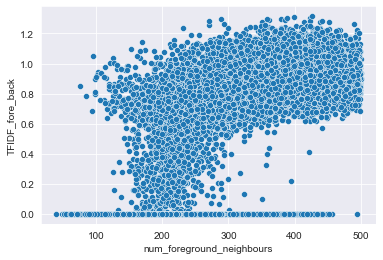

In [327]:
sns.set_style ("darkgrid")
sns.scatterplot(x="num_foreground_neighbours",
                y="TFIDF_fore_back",
                data=span_features_df)

There seems to be some sort of correlation between:
1. the number of foreground neighbours
2. the TF-IDF inspired value for a span 

We'll assume that general background domain terms have:
* a TF-IDF value that is very close to 0
* a relatively small number of foreground terms, e.g., cut-off at 200/500

In [328]:
min_TFIDF_value = 0.2
min_num_foreground_neighbours = 200

domain_terms = span_features_df[(span_features_df['TFIDF_fore_back'] >= min_TFIDF_value) & (span_features_df['num_foreground_neighbours'] >= min_num_foreground_neighbours)]
ood_terms = span_features_df[(span_features_df['TFIDF_fore_back'] < min_TFIDF_value) | (span_features_df['num_foreground_neighbours'] < min_num_foreground_neighbours)]


In [329]:
print(f"Examples of our {len(domain_terms)} AEC domain terms")
random.sample(domain_terms.index.tolist(), 10)

Examples of our 10402 AEC domain terms


['loft conversions',
 'FD 30 S',
 'The wall finish',
 'Address Postcode',
 'new dwellings Approved Document L1B Conservation',
 'Building dimensions',
 'Smoke testing',
 'rated',
 'Approved Inspectors',
 'the ASFP Grey Book']

In [330]:
print(f"Examples of our {len(ood_terms)} general domain terms")
random.sample(ood_terms.index.tolist(), 10)

Examples of our 6039 general domain terms


['the acceptance criteria',
 'filtration',
 'a university',
 'purpose knowledge',
 'Article 49',
 'design characteristics',
 'the overall process',
 'operators',
 'connectors',
 'EC DECLARATION OF']

<div class="alert alert-block alert-info">
Fifth, we'll also try a clustering-based approach. This means we have to pick a value for K ~ the number of clusters. K determines roughly how many terms are filtered (each cluster that has a background term in it), a low K will have many terms removed and a high K will have few terms removed.
</div>

* As a heuristic for determining a reasonable value for K we rely on the Elbow method and sillhouette score; these are not optimal solutions but this doesn't matter much in our case. 
  * In general, our dataset is larger and more diverse than usually desired with KMeans. As an example, a rule of thumb for selecting K is the square root of half the number of samples `k = (16000/2)**.5 = 89.4`. This is a completely unrealistic value of K for our usecase, as it would mean there are only 90-odd concepts that occur in our sets of input corpora.
  * However, elbow and sillhouette scores, as well as gap statistics, show how hard it is to cluster our data.
  

In [46]:
# clustering approach (I think I'll simply use the kNN approach)
def compute_clusters_sklearn(standardised_clustering_data, cluster_model_fp, num_clusters=10):
    """
    Note that this clustering function relies on the CPU. It won't be able to compute clusters for large 
    amounts of inputs, e.g., 100.000 spans. When using a large number of clusters (e.g. 20K) it is also
    a lot slower than a GPU implementation for. Or it may simply not converge! 
    For large inputs/num_clusters you'll need to use compute_clusters_kmcuda, and have access to a GPU.
    """
    print(f"Computing {num_clusters} clusters from scratch, using sklearn on the CPU")
    start_time = time.time()
    sklearn_kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=5, n_init=1, random_state=14,
                            tol=0.0001, verbose=0)
    assignments = sklearn_kmeans.fit_predict(standardised_clustering_data)
    centroids = sklearn_kmeans.cluster_centers_
    print("Clustering took {}".format(time.time() - start_time))
    with open(cluster_model_fp, 'wb') as f:
        pickle.dump((centroids, assignments), f)

In [47]:
clustering_type = "sklearn"   # deprecated; we're only using the sklearn implementation of kmeans 
# Computing clusters on the CPU
for num_clusters in range(500,12001, 500):
    cluster_file = f"output/sklearn_{num_clusters}_clusters.pkl"
    if not os.path.exists(cluster_file):
        compute_clusters_sklearn(standardised_clustering_data, cluster_file, num_clusters)
    else:
        print(f"sklearn cluster file exists for {num_clusters} clusters")

sklearn cluster file exists for 500 clusters
sklearn cluster file exists for 1000 clusters
sklearn cluster file exists for 1500 clusters
sklearn cluster file exists for 2000 clusters
sklearn cluster file exists for 2500 clusters
sklearn cluster file exists for 3000 clusters
sklearn cluster file exists for 3500 clusters
sklearn cluster file exists for 4000 clusters
sklearn cluster file exists for 4500 clusters
sklearn cluster file exists for 5000 clusters
sklearn cluster file exists for 5500 clusters
sklearn cluster file exists for 6000 clusters
sklearn cluster file exists for 6500 clusters
sklearn cluster file exists for 7000 clusters
sklearn cluster file exists for 7500 clusters
sklearn cluster file exists for 8000 clusters
sklearn cluster file exists for 8500 clusters
sklearn cluster file exists for 9000 clusters
sklearn cluster file exists for 9500 clusters
sklearn cluster file exists for 10000 clusters
sklearn cluster file exists for 10500 clusters
sklearn cluster file exists for 1

In [48]:
clustering_files = glob.glob(f'output/{clustering_type}_*.pkl')

Computing elbow and silhouette (if not too many num_clusters) scores.


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 1493.37it/s]

Loading values from existing csv file: output/sklearn_4500_clusters.pkl
Loading values from existing csv file: output/sklearn_5000_clusters.pkl
Loading values from existing csv file: output/sklearn_3500_clusters.pkl
Loading values from existing csv file: output/sklearn_2000_clusters.pkl
Loading values from existing csv file: output/sklearn_12000_clusters.pkl
Loading values from existing csv file: output/sklearn_500_clusters.pkl
Loading values from existing csv file: output/sklearn_2500_clusters.pkl
Loading values from existing csv file: output/sklearn_3000_clusters.pkl
Loading values from existing csv file: output/sklearn_5500_clusters.pkl
Loading values from existing csv file: output/sklearn_4000_clusters.pkl
Loading values from existing csv file: output/sklearn_1000_clusters.pkl
Loading values from existing csv file: output/sklearn_11500_clusters.pkl
Loading values from existing csv file: output/sklearn_10000_clusters.pkl
Loading values from existing csv file: output/sklearn_7500_clu

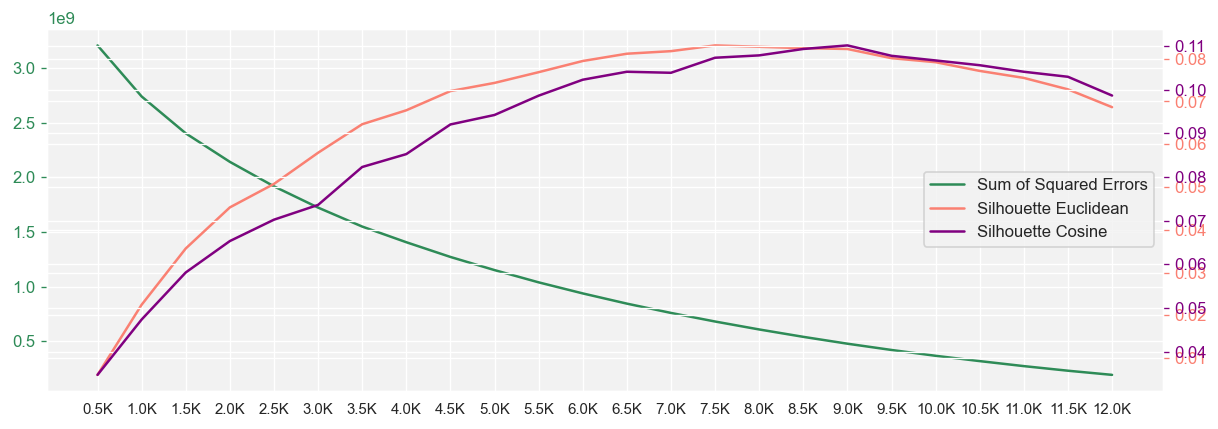

In [49]:
# This takes a bit of time; 6-10 minutes per cluster size for 2000-6000 clusters 
# but resulting scores are saved in a csv and reused
clustering_data_fp = "output/"
es = cluster_utils.ElbowAndSilhouette(clustering_data_fp)
es.compute_scores_for_models(clustering_type, clustering_files)

* Sum of Squared Errors (SSE) is an indication of the sum of squared distances between points in a cluster and the cluster centroid.
* The silhouette score of a point measures how close that point lies to its nearest neighbor points, across all clusters. 

While SSE and the silhouette score are often used for determining a good value for K, they do not always provide the right type of insight in the optimal K. Better alternatives exist (Schubert, 2022) and one of these options is the gap statistic (Tibshirani et al., 2001).

In [50]:
optimalK = OptimalK(n_jobs=6, parallel_backend='joblib')

In [51]:
n_clusters = optimalK(standardised_clustering_data, cluster_array=np.arange(1, 16002, 500))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages/scipy/cluster/vq.py:607: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  warnings.warn("One of the clusters is empty. "
/Users/rubenkruiper/.conda/envs/haystack/lib/python3.9/site-packages

In [52]:
optimalK.gap_df.head()

,n_clusters,gap_value,gap*,ref_dispersion_std,sk,sk*,diff,diff*
0,1.0,2.210988,1.025885e+08,7135.882330,0.000072,1.184590e+08,-0.565284,1.184761e+08
1,501.0,2.776632,1.026987e+08,34124.441840,0.000360,1.185862e+08,-0.083146,1.180754e+08
2,1001.0,2.860049,9.939639e+07,24785.999472,0.000271,1.147731e+08,-0.068573,1.142561e+08
3,1501.0,2.929071,9.605448e+07,39475.892855,0.000449,1.109142e+08,-0.039773,1.103806e+08
4,2001.0,2.969036,9.260567e+07,16214.356334,0.000192,1.069318e+08,-0.041016,1.063944e+08


In [53]:
print(f"Optimal number of clusters: {n_clusters}")

Optimal number of clusters: 16001


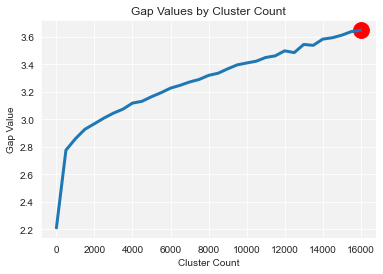

In [55]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

Based on the Elbow score, we might expect K to lie around 3000. But based on the sillhouette scores the ideal K may be closer to 7500.




* Based on the number of clusters we'd like to use, we create a lookup-dictionary for the embedding and assigned cluster of each span

In [56]:
chosen_num_clusters = 7500
cluster_model_to_use = f'output/{clustering_type}_{chosen_num_clusters}_clusters.pkl'

In [57]:
centroids, assignments = pickle.load(open(cluster_model_to_use, 'rb'))

unique_background_terms = [k for k in background_terms_c.keys()]
cluster_dict_creator = cluster_utils.ClusterDict(unique_background_terms, 
                                                 unique_spans, 
                                                 standardised_clustering_data,  # important to use standardised embeddings
                                                 centroids, 
                                                 assignments,
                                                 embedding_fp="output/")

In [58]:
phrase_cluster_dict, clusters_to_filter = cluster_dict_creator.prep_cluster_dict(chosen_num_clusters)

Loading a pre-computed cluster dictionary from file.


In [65]:
# print some insight in the clusters
max_terms_to_show = 5
for k in random.sample(phrase_cluster_dict.keys(), 10):
    some_terms = [span for score, span in phrase_cluster_dict[k]]
    if k in clusters_to_filter:
        print(f"Filtered: {some_terms[:max_terms_to_show]}")
    else:
        print(f"AEC domain: {some_terms[:max_terms_to_show]}")

AEC domain: ['the stair width', 'the stair landing', 'a stair lobby', 'the stair lobby', 'a stair width']
Filtered: ['the preceding sentence']
Filtered: ['mechanical risks', 'thermal risks']
Filtered: ['management resources']
AEC domain: ['sap2012']
AEC domain: ['fibre cement pipes']
Filtered: ['Union language']
Filtered: ['developments', 'issues', 'conventions', 'treatments', 'tools']
AEC domain: ['minimum area 7600 mm2']
AEC domain: ['Approved Document L2A', 'Approved Document L1A', 'Approved Document L1B', 'Approved Document L2B', 'Approved Document H2']


/var/folders/lp/l_mzhpjs6bg95plfkl_n_vsc0000gn/T/ipykernel_33437/378847011.py:3: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  for k in random.sample(phrase_cluster_dict.keys(), 10):


In [66]:
removed_terms = [span for k, v in phrase_cluster_dict.items() for score, span in v if k in clusters_to_filter]

In [67]:
filtered_terms = [t for t in removed_terms if t in foreground_terms]

In [68]:
domain_terms = [span for k, v in phrase_cluster_dict.items() for score, span in v  if k not in clusters_to_filter]

In [69]:
print("{} terms were filtered ({:.2f}%)".format(len(filtered_terms), len(filtered_terms)/len(filtered_terms+domain_terms)*100))
print("Terms that were filtered:")
random.sample(filtered_terms,10)

3536 terms were filtered (30.49%)
Terms that were filtered:


['activity',
 'the common access point',
 'standing',
 'cooking',
 'lift',
 'jointing',
 'the boundaries',
 'coal',
 'the situation',
 'correct']

In [70]:
print("{} terms were kept ({:.2f}%)".format(len(domain_terms), len(domain_terms)/len(filtered_terms+domain_terms)*100))
print("Terms that were kept:")
random.sample(domain_terms,10)

8063 terms were kept (69.51%)
Terms that were kept:


['Diagram 11',
 'balustrade',
 'biometric data',
 'The Society',
 'person self - certification scheme',
 'an emergency escape window',
 'fire resisting enclosures',
 'the average U - value',
 'thick classification',
 'Of screwed steel']

In [71]:
cluster_sizes = [len(v) for v in phrase_cluster_dict.values()]
print(f'Average number of terms per cluster: {sum(cluster_sizes)/len(cluster_sizes)}')


Average number of terms per cluster: 2.1921333333333335


In [72]:
# Check the largest cluster(s)
largest_cluster_size = np.max([len(v) for v in phrase_cluster_dict.values()])
print(largest_cluster_size)
[v for v in phrase_cluster_dict.values() if len(v) == largest_cluster_size]

55


[[[159.29367065429688, 'adverse'],
  [187.3153533935547, 'absorption'],
  [188.1763916015625, 'practical'],
  [196.63951110839844, 'surgical'],
  [207.51983642578125, 'permanent'],
  [208.10569763183594, 'failure'],
  [213.1658477783203, 'intervention'],
  [213.35540771484375, 'active'],
  [215.70858764648438, 'invasive'],
  [215.78912353515625, 'exempt'],
  [217.611572265625, 'joint'],
  [219.036865234375, 'plastic'],
  [220.65252685546875, 'activity'],
  [220.78814697265625, 'confidential'],
  [221.96163940429688, 'validity'],
  [222.2523956298828, 'supplement'],
  [226.98455810546875, 'private'],
  [229.7158203125, 'excessive'],
  [230.33895874023438, 'floating'],
  [233.13958740234375, 'resistant'],
  [234.1645050048828, 'disposal'],
  [236.387451171875, 'basin'],
  [236.43263244628906, 'adjustment'],
  [239.93380737304688, 'bedrooms'],
  [241.37928771972656, 'reinforced'],
  [246.22830200195312, 'occupants'],
  [247.08599853515625, 'robust'],
  [247.97427368164062, 'cooling'],
  [

In [73]:
# check the smallest clusters, select 10 examples
print(len([v for v in phrase_cluster_dict.values() if len(v) == 1]))
random.sample([v for v in phrase_cluster_dict.values() if len(v) == 1], 10)

4836


[[[0.0, 'European Union']],
 [[0.0, 'sympathetic treatment']],
 [[0.0, 'secure containers']],
 [[0.0, 'Inner rooms']],
 [[0.0, 'Regulation continued 3']],
 [[0.0, 'the centreline']],
 [[0.0, 'Technical aspects']],
 [[0.0, 'section G2']],
 [[0.0, 'Legal status']],
 [[0.0, 'a refuse chute']]]

### 4 Suggesting similar terms for Uniclass

<div class="alert alert-block alert-info">
Here we predict (1) expansion candidates and (2) potential inflections (based on Levenshtein distance) for a given term. 
</div>


* We run our algorithm on all Uniclass terms to get a feel for the output we generate.

In [78]:
class ClusterAssignment:
    def __init__(self, pkl_model, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter):
        """
        It's important to use the standardised clustering data here!
        """
        self.centroids, self.assignments = pickle.load(open(pkl_model, 'rb'))
        self.num_clusters = int(max(self.assignments) + 1)
        
        # set up sklearn for prediction
        cpu_centroids = np.nan_to_num(self.centroids, copy=True, nan=0.0, posinf=None, neginf=None)
        self.cpu_clusterer = KMeans(self.num_clusters, init=cpu_centroids, n_init=1, max_iter=1, tol=0)
        print("[Clustering] Initialising sklearn kMeans with 1 iteration on KMcuda outputs. This takes some time!")
        self.cpu_clusterer.fit(standardised_clustering_data)
        
        self.embedder = embedder
        self.unique_span_dict = dict(zip(unique_spans, standardised_clustering_data))
        self.cluster_dict = phrase_cluster_dict
        self.clusters_to_filter = clusters_to_filter
    

    def sklearn_assign(self, to_be_clustered: List[cluster_utils.ToBeClustered]) -> List[cluster_utils.ToBeClustered]:
        """
        Using SciKit Learn's CPU implementation of KMeans to assign cluster IDs to a span or list of spans.

        :param to_be_predicted: A `str` or `list` of strings for which a cluster ID will be computed.
        :return :   List of cluster IDs.
        """
        # Note: we try to avoid iteratively assigning clusters for each item in a list - don't think we parallelize more
        embeddings = [s.embedding for s in to_be_clustered]
        arrays = [np.ones([1, 768]).astype(np.float32) for _ in to_be_clustered]

        for i, e in enumerate(embeddings):
            arrays[i][0] = np.stack(e.squeeze())  # .astype(np.float16)

        assignments = []
        for arr in arrays:
            assignments.append(self.cpu_clusterer.predict(arr))

        for idx, assignment in enumerate(assignments):
            to_be_clustered[idx].cluster_id = str(int(assignment))
#             print(f"assigned ID: {str(int(assignment))}")
            to_be_clustered[idx].distance_to_centroid = np.sum(np.absolute(embeddings[idx]-self.centroids[assignment]))
            to_be_clustered[idx].all_neighbours = self.cluster_dict[str(int(assignment))]

        return to_be_clustered
    
    def get_top_neighbours(self, 
                           text_inputs : Union[List[str], str], 
                           cosine_sim_threshold: float = 0.7, 
                           top_k: int = 3,
                           return_non_aec=False):
        if type(text_inputs) == str:
            NON_AEC = False
            tbc = cluster_utils.ToBeClustered(text_inputs, embedder)
            [tbc] = self.sklearn_assign([tbc])
            if tbc.cluster_id in self.clusters_to_filter:
#                 print(f"Potentially non-AEC domain: {tbc.text}")
                NON_AEC = True
                
            if not return_non_aec and NON_AEC:
                return [], []
            else:
                neighbours, inflections = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                return neighbours, inflections
        else:
            tbcs = [cluster_utils.ToBeClustered(t, embedder) for t in text_inputs]
            tbcs = self.sklearn_assign(tbcs)
            neighbours = []
            inflections = []
            for tbc in tbcs:
                NON_AEC = False
                if tbc.cluster_id in self.clusters_to_filter:
#                     print(f"Potentially non-AEC domain: {tbc.text}")
                    NON_AEC = True
                if not return_non_aec and NON_AEC:
                    neighbours.append([])
                    inflections.append([])
                else:
                    n, i = tbc.get_top_k_neighbours(self.unique_span_dict, cosine_sim_threshold, top_k)
                    neighbours.append(n)
                    inflections.append(i)
            return neighbours, inflections
        

In [79]:
cluster_assigner = ClusterAssignment(cluster_model_to_use, embedder, unique_spans, standardised_clustering_data, phrase_cluster_dict, clusters_to_filter)

[Clustering] Initialising sklearn kMeans with 1 iteration on KMcuda outputs. This takes some time!


* some examples of assigning clusters and identifying neighbours for spans:

In [80]:
# example str input
example_string = "party wall"
neighbours, inflections = cluster_assigner.get_top_neighbours(example_string, cosine_sim_threshold=.7)
print("neighbours", neighbours)
print("inflections", inflections)

neighbours []
inflections ['party walls', 'Party walls']


In [81]:
# example list of str input
example_strings = ["a structural member", "control equipment"]
neighbours, inflections = cluster_assigner.get_top_neighbours(example_strings, 
                                                              cosine_sim_threshold=.7, 
                                                              return_non_aec=True)
for idx, (neighbour_list, inflection_list) in enumerate(zip(neighbours, inflections)):
    print(example_strings[idx])
    print("neighbours", neighbour_list)
    print("inflections", inflection_list)


a structural member
neighbours []
inflections ['the structural members']
control equipment
neighbours ['test equipment', 'electrical equipment']
inflections ['control equipment']


<div class="alert alert-block alert-info">
We read Uniclass terms from a .ttl file that we have previoulsy prepared.
</div>

In [82]:
def group_ttl_lines(text):
    groups = []
    current_group = []
    for idx, line in enumerate(text.split("\n")):
        if line == '':
            if current_group:
                groups.append(current_group)
            current_group = []
        else:
            current_group.append(line)
            if idx+1 == len(text.split("\n")):
                groups.append(current_group)
    return groups

In [83]:
def grab_uids_and_labels_with_definition(groups):
    uid_dict = {}
    for g in groups:
        if any([line.startswith('  skos:prefLabel') for line in g]):
            # only use group if a prefLabel exists
            pref_label = ''
            alt_labels = []
            definition = ''
            for line in g:
                if line.startswith('  skos:prefLabel'):
                    pref_label = line.split('"')[1]
                elif line.startswith('  skos:altLabel'):
                    labels = line.split('"')[1::2]
                    alt_labels += labels
                elif line.startswith('  skos:definition'):
                    definition = line.split('"')[1]

            if pref_label:
                uid = g[0].split()[0].split(":")[1]
                uid_dict[uid] = {'pref_label': pref_label, 
                                 'alt_labels': alt_labels,
                                 'definition': definition
                                }
    return uid_dict


In [84]:
def grab_nodes(vocab_name):
    processed_file = f"{vocab_name}.json"
    
    # check if file as processed before 
    NODES_LOADED = False
    if os.path.exists(processed_file):
        with open(processed_file) as f:
            graph_dict = json.load(f)
            
        NODES_LOADED = True
        print(f"Loaded nodes and neighbours for: {vocab_name}") 
    else: 
        print(f"Will have to grab nodes for: {vocab_name}")
    
        # compute the neighbours for each node
        graph_dict = {}
        
        print(f"Working on file: {vocab_name}")
        with open(vocab_name, 'r') as f:
            text =  f.read()
            
        groups = group_ttl_lines(text)
        print("Collecting nodes with definitions from dict")
        graph_dict = grab_uids_and_labels_with_definition(groups)
        
        # save the dictionary somewhere for reloading
        with open(processed_file, 'w') as f:
            json.dump(graph_dict, f)
    return graph_dict

In [85]:
uniclass_dict = grab_nodes("data/input/uniclass_2015.ttl")

Loaded nodes and neighbours for: data/input/uniclass_2015.ttl


In [86]:
len(uniclass_dict)

15020

* Feed the Uniclass labels to our predictor

In [87]:
expansion_candidates =  {}
for k, v in tqdm(uniclass_dict.items()):
    uniclass_label = v['pref_label']
    if uniclass_label:
        expansion_terms, inflections = cluster_assigner.get_top_neighbours(uniclass_label, 
                                                                           cosine_sim_threshold=.7,
                                                                           top_k=5,
                                                                           return_non_aec=False)
        expansion_candidates[uniclass_label] = {"expansions": expansion_terms,
                                                "inflections": inflections}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15020/15020 [53:32<00:00,  4.68it/s]


In [88]:
def print_expansion_candidates(expansion_candidates: Dict[str, str]):
    number_of_terms_with_expansion_candidates = 0
    for k, v in expansion_candidates.items():
        if v['expansions'] or v['inflections']:
            print(f"==========================\nTerm: {k}")
            print(f"Related: {v['expansions']}")
            print(f"Inflections: {v['inflections']}")
            number_of_terms_with_expansion_candidates += 1

    print("\n\n\nAmount of terms with candidates:\n{} ({:.2f}%)".format(
        number_of_terms_with_expansion_candidates,
        number_of_terms_with_expansion_candidates/len(expansion_candidates)*100))
    

In [89]:
print_expansion_candidates(expansion_candidates)

Term: Inspecting
Related: []
Inflections: ['Inspection']
Term: Plumbing
Related: ['Plumbing fittings']
Inflections: []
Term: Remediation, repair and renovation
Related: ['remediation']
Inflections: []
Term: Remediation
Related: []
Inflections: ['remediation']
Term: Repair
Related: []
Inflections: ['Repair']
Term: Cold water and water treatment systems surveying
Related: ['hot water storage systems']
Inflections: ['a hot water storage system', 'hot water storage system', 'hot water supply systems']
Term: Escalator and moving pavement systems surveying
Related: ['Escalators']
Inflections: []
Term: Sprinkler systems surveying
Related: ['The sprinkler system', 'Design of sprinkler systems E3', 'non - residential sprinkler systems', 'The sprinkler water supplies', 'an automatic sprinkler system']
Inflections: ['the sprinkler system', 'a sprinkler system', 'With sprinkler system']
Term: Geoenvironmental exploratory investigating
Related: ['Geoenvironmental Specialists']
Inflections: []
Term:

Related: ['Thermoplastic rooflights']
Inflections: ['thermoplastic rooflights']
Term: Entrance mats
Related: ['Entrance doors']
Inflections: ['Entrance hall']
Term: Decorative papers and roll coverings
Related: ['Decorative wall coverings']
Inflections: []
Term: Agglomerated composition cork tiles with polyvinyl chloride (PVC) wearing layer
Related: ['multi - skinned polycarbonate sheet products', 'rigid solid polycarbonate sheet products']
Inflections: []
Term: Cork-backed polyvinyl chloride (PVC) sheets
Related: ['rigid solid polycarbonate sheet products', 'multi - skinned polycarbonate sheet products']
Inflections: []
Term: Cork-backed polyvinyl chloride (PVC) tiles
Related: ['rigid solid polycarbonate sheet products']
Inflections: []
Term: Ethylene propylene diene monomer (EPDM) rubber tiles
Related: ['polyethylene sheet', 'polyethylene']
Inflections: []
Term: Filled fibrous-backed polyvinyl chloride (PVC) sheets
Related: ['rigid solid polycarbonate sheet products', 'multi - skinne

Related: ['Aluminium']
Inflections: []
Term: Pipeline renovation systems
Related: ['the Pipelines Safety Regulations 1996']
Inflections: ['The Pipelines Safety Regulations 1996 ii']
Term: Structural systems
Related: ['Structural design']
Inflections: []
Term: Concrete foundation systems
Related: ['Concrete']
Inflections: []
Term: Precast concrete pad and strip foundation systems
Related: ['precast concrete floors']
Inflections: []
Term: Precast concrete foundation and plinth systems
Related: ['precast concrete cladding']
Inflections: []
Term: Interstitial grouting systems
Related: ['interstitial']
Inflections: []
Term: Structural frame systems
Related: ['Structural design']
Inflections: []
Term: Pipe bridge systems
Related: ['Pipework']
Inflections: []
Term: Prefabricated framed and panelled structures
Related: ['prefabricated components']
Inflections: []
Term: Glazed enclosure systems
Related: ['Glazed surfaces', 'Glazing']
Inflections: []
Term: Modular pod systems
Related: ['Modular'

* Our own list of terms of interest

In [90]:
terms_of_interest = ['Timber frame floors and roofs',  'EPS',  'Water services',  'Subsystems',  'External thermal insulation composite system with rendering ',  'Smoke and fire-stopping',  'Timber baseboards',  'PV panels',  'Ceramic slates',  'Vertical smoke strip curtains',  'Hardwood deck boards',  'Roof type',  'Flat roof ',  'Aluminium external panels',  'Material',  'Ethylene propylene (EP) damp-proof courses and cavity trays',  'Vertical smoke curtains',  'Light-gauge steel floors and roofs',  'Fibre-cement',  'Fibre-reinforced cement boards',  'Services',  'Fire alarm systems',  'HVAC equipment',  'Covering',  'Mineral wool insulation',  'Components',  'Roof structure - flat',  'CLT',  'Aluminium cassette panels',  'Fibre-reinforced cement sheets',  'Weathering steel cassette panels',  'Clay roofing tiles',  'Batteries',  'Natural stone',  'Bitumen-based damp-proof courses and cavity trays',  'Board suspended ceiling systems',  'Green roofs/gardens',  'Maintenance access',  'Softwood baseboards',  'Polyurethane (PUR) foam boards',  'Sheet panels',  'Glulam',  'Flexible sheet for waterproofing',  'Panelled and framed modular systems',  'Vertical active fire curtain barriers',  'Gypsum core boards',  'Barriers',  'Light steel roof framing systems',  'Natural stone panels',  'Timber sheet panels',  'Mineral wool wire-reinforced mattress cavity barriers',  'Structural frame',  'Aluminium internal panels',  'Roof diaphragm',  'Structural connectors',  'Timber',  'Roof windows',  'Reinforced concrete',  'Ceramic tiles',  'LWSF - Light weight steel-frame',  'Panel of steel-wires with incorporated thermal insulation',  'Water tightness',  'Structural',  'Structural insulated panel systems',  'Cold-applied roofing membrane adhesive damp-proof course joint sealers',  'Mineral fibre slab insulation',  'Cross-laminated timber (CLT) panelled modules',  'Membranes',  'Ceiling and soffit systems',  'Green roof',  'Skylights',  'Extruded polyethylene (PE) foam boards',  'Plain tile roofing systems',  'Wood-based panels',  'Blue roof',  'Insulated damp-proof courses',  'Interfacial',  'Light-gauge steel frame panels',  'Aluminium structures',  'Timber board panels',  'Bitumen membrane shingles',  'Mastic asphalt (MA) damp-proof courses',  'Deck frame',  'ICT',  'Gypsum baseboards',  'Flexible stone wool mat insulation',  'Pitched roof ',  'Fire insulating caps',  'Active smoke barriers',  'Fibre cement slate roofing systems',  'Steel structures',  'Photovoltaic devices',  'Structural insulated panel (SIP) modules',  'Mineral wool slab insulation',  'XPS',  'Sound proofing',  'Ceiling cassettes',  'Highlighted relevant item',  'Hardboards',  'Intumescent sleeved mineral wool cavity fire barriers',  'Thermal insulation',  'Solar photovoltaic modules',  'Wood structures',  'Aluminium-faced aluminium core panels',  'Steel deck',  'P-DfMA Standards Database',  'Rain drainage',  'Polymeric damp-proof courses',  'Active Roof',  'Flexible intumescent gap seals',  'Bonded sheets',  'Underlays for discontinuous roofing',  'Bitumen sheets',  'Prefabricated framed and panelled structures',  'Panels',  'Composite',  'Active roof',  'Sealants',  'Building elements',  'Hardwood baseboards',  'Light gauge steel frame',  'Mineral wool flexible insulation',  'Energy storage',  'Air tightness',  'Passive roof',  'Ceramic panels',  'Vapour control layer',  'Mineral wool',  'Energy generation and storage',  'Softwood deck boards',  'Ceramic fibre fire-stopping',  'Intumescent linear gap seals',  'Gypsum plasterboards',  'Oriented strand boards',  'Non-loadbearing',  'Wood-based boards',  'Roof-mounted photovoltaic',  'Tapered insulation',  'Solar thermal systems',  'Carbon steel insulating sandwich panels',  'Fire detection',  'LVL',  'Fibre-cement slates',  'Insulation',  'Cold roof ',  'Self-supporting double skin metal faced insulating panels',  'Composite panels',  'Carbon steel framed vertical bar and rail panels',  'Mineral wool fire-stopping',  'Warm roof ',  'Damp-proof courses and cavity trays',  'Flexible plasterboards',  'Superstructure',  'Prefabricated building units ',  'Aluminium composite material (ACM) panels',  'Natural slates',  'Fire-fighting systems',  'Mechanical services',  'Bitumen membrane shingle roofing systems',  'Wood laminate strips and boards',  'Ceramic',  'PIR',  'Plastics membranes',  'Extruded polystyrene (XPS) boards',  'Composite lightweight panels',  'Bitumen membrane',  'Rainwater harvesting',  'Coated woven glass fibre cloth flexible cavity barriers',  'Wood fibre boards',  'Polyisocyanurate (PIR) foam boards',  'Timber lining boards',  'Pre-fabricated wood-based loadbearing stressed skin panels',  'External wall',  'Fully bonded pre applied flexible sheet for water proofing ',  'Plywood desk',  'Load bearing',  'Concrete roofing tiles',  'Expanded polystyrene (EPS) boards',  'Timber structures']

In [91]:
term_expansion_candidates =  {}
for term in tqdm(terms_of_interest):
#     term = term if term.isupper() else term.lower() # remove capitalisation if not an abbreviation
    expansion_terms, inflections = cluster_assigner.get_top_neighbours(term, 
                                                                       cosine_sim_threshold=.7,
                                                                       top_k=5,
                                                                       return_non_aec=False)
    term_expansion_candidates[term] = {"expansions": expansion_terms,
                                       "inflections": inflections}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 179/179 [00:13<00:00, 13.67it/s]


In [92]:
print_expansion_candidates(term_expansion_candidates)

Term: EPS
Related: ['EPC']
Inflections: []
Term: Water services
Related: ['Water supply']
Inflections: ['the water supply', 'the Water Supply']
Term: External thermal insulation composite system with rendering 
Related: ['insulating core panels']
Inflections: []
Term: Smoke and fire-stopping
Related: ['fire - stopping']
Inflections: ['Fire - stopping', 'fire - stopped']
Term: Timber baseboards
Related: ['Timber cladding']
Inflections: []
Term: Roof type
Related: ['Roof']
Inflections: []
Term: Flat roof 
Related: []
Inflections: ['Flat roof', 'flat roof', 'flat roofs']
Term: Aluminium external panels
Related: ['Aluminium alloy']
Inflections: []
Term: Fibre-cement
Related: []
Inflections: ['Fibre - cement']
Term: Fibre-reinforced cement boards
Related: ['Fibre - cement']
Inflections: []
Term: Fire alarm systems
Related: ['Fire detection alarm systems']
Inflections: ['fire detection alarm system', 'the fire detection alarm system', 'a fire detection alarm system']
Term: HVAC equipment
Rel

* Identify candidate mappings based on overlap in expansion candidates and inflections

In [93]:
for k1, v1 in term_expansion_candidates.items():
    potential_uniclass_matches = []
    for k2, v2 in expansion_candidates.items(): 
        if any([candidate for candidate in v1['expansions'] + v1['inflections'] if (candidate in v2['expansions'] or candidate in v2['inflections'])]):
            potential_uniclass_matches.append(k2)
    if potential_uniclass_matches:
        print(f"Match?===============\nBRE: {k1}\nUniclass: {potential_uniclass_matches}\n")

Match?===============
BRE: Water services
Uniclass: ['Water supply']

Match?===============
BRE: External thermal insulation composite system with rendering 
Uniclass: ['Carbon steel insulating sandwich panels', 'Cellular glass insulation boards']

Match?===============
BRE: Smoke and fire-stopping
Uniclass: ['Smoke and fire-stopping']

Match?===============
BRE: Timber baseboards
Uniclass: ['Timber baseboards']

Match?===============
BRE: Aluminium external panels
Uniclass: ['Aluminium alloy bollards', 'Aluminium alloy hinged bollards', 'Aluminium alloy telescopic bollards', 'Aluminium curtain wall frame sections', 'Aluminium extruded bars and rods', 'Aluminium extruded precision profiles', 'Aluminium structural sections', 'Aluminium extruded tubes', 'Aluminium alloy posts', 'Aluminium alloy rails', 'Aluminium support rails', 'Aluminium carrier rails', 'Aluminium structural beams', 'Aluminium structural columns', 'Aluminium wires', 'Aluminium cold-formed planks', 'Aluminium edging sec

Match?===============
BRE: Structural
Uniclass: ['Structural elements', 'Structural performance requirements', 'Structural design performance requirements', 'Structural fire performance requirements', 'Structural engineering design strategy', 'Structural anchors', 'Structural roofing units', 'Structural units', 'Structural systems', 'Structural frame systems', 'Structural framing systems', 'Structural beam systems', 'Structural columns', 'Structural column systems', 'Structural glass wall systems', 'Structural deck systems', 'Structural monitoring systems', 'Structural members']

Match?===============
BRE: Membranes
Uniclass: ['Membrane structures', 'Geomembranes', 'Membrane walkways', 'Membrane walkway coatings', 'Membrane water filters', 'Membrane filtration systems']

Match?===============
BRE: Skylights
Uniclass: ['Skylights']

Match?===============
BRE: Extruded polyethylene (PE) foam boards
Uniclass: ['High-density polyethylene (PE-HD) geonets', 'Chlorinated polyethylene (PE-C) g

Match?===============
BRE: Prefabricated building units 
Uniclass: ['Prefabricated buildings and structures', 'Prefabricated balconies', 'Prefabricated continuity reinforcement strips', 'Prefabricated reinforcement', 'Low-voltage prefabricated cables', 'Prefabricated wiring switches', 'Prefabricated framed and panelled structures', 'Prefabricated room systems', 'Prefabricated metal wall systems', 'Prefabricated glass block wall systems', 'Prefabricated wood or plastics panel fencing systems', 'Prefabricated inlet works systems', 'Low-voltage small power systems with prefabricated wiring', 'General lighting systems with prefabricated wiring', 'Prefabricated scaffold']

Match?===============
BRE: Aluminium composite material (ACM) panels
Uniclass: ['Aluminium alloy bollards', 'Aluminium alloy hinged bollards', 'Aluminium alloy telescopic bollards', 'Aluminium curtain wall frame sections', 'Aluminium extruded bars and rods', 'Aluminium extruded precision profiles', 'Aluminium structural s